In [1]:
#Importar as bibliotecas
import ee
import geemap
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [2]:
#Autenticação do GEE
ee.Authenticate()
ee.Initialize(project='projetos-beatriz')

In [3]:
#Selecionar área de interesse
roi = ee.Geometry.Polygon(
        [[[-45.52915939540454, -12.226348798370193],
          [-45.504611818500244, -12.229033070472461],
          [-45.49819472567395, -12.212530344463545],
          [-45.490984947841916, -12.195248788725634],
          [-45.49991133944348, -12.181657647646674],
          [-45.510726006191526, -12.173603309643935],
          [-45.52085402743176, -12.164709694354997],
          [-45.540938408535276, -12.153298582315157],
          [-45.56479933993176, -12.165380920988163],
          [-45.55861953036145, -12.180986462146171],
          [-45.547461540859494, -12.21018146135253]]]);

In [4]:
#Selecionar o período das imagens (ano de início e ano de fim)
#Image Collection - Coleção de imagens ao longo de um período
##Imagens do Sentinel-2 Surface Reflectance (BOA)
###Filtrar as imagens pela área de interesse
###Filtrar as imagens que tenham menos de 1% de cobertura de nuvem

start_date = '2020-01-01'
end_date = '2023-12-31'

imagecollection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                       .filterBounds(roi)\
                       .filterDate(start_date, end_date)\
                       .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1))

In [5]:
#Calcular o fator de escala

def scale(image):
  return ee.Image(image.multiply(0.0001).clip(roi).copyProperties(image, image.propertyNames()))

#Calcular o NDVI

def index(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
  return image.addBands(ndvi)

In [6]:
#Aplicar o fator de escala e o ndvi para todas as imagens

ndvi_images = imagecollection.map(scale).map(index)

In [7]:
#Calcular a média do valor de NDVI em cada imagem
#Extrair a data da imagem como uma string no formato 'Year - Month - Day'

def reduce(image):
  ndvi_mean = image.reduceRegion(
      reducer = ee.Reducer.mean(),
      geometry = roi,
      scale = 30
  ).get('NDVI')
  data = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
  return ee.Feature(None, {'data':data, 'NDVI':ndvi_mean})

In [8]:
#Aplicar a função anterior em cada imagem da coleção

ndvi_time_series = ndvi_images.map(reduce)

In [9]:
#Agrupamento dos dados (datas e valores de ndvi) em listas
#Conversão do formato usado no Google Earth Engine para um legível em Python

dates = ndvi_time_series.aggregate_array('data').getInfo()
ndvi_values = ndvi_time_series.aggregate_array('NDVI').getInfo()

In [10]:
#Formatação das datas
##Conversão das datas para objetos datetime

dates = [datetime.strptime(data, '%Y-%m-%d') for data in dates]

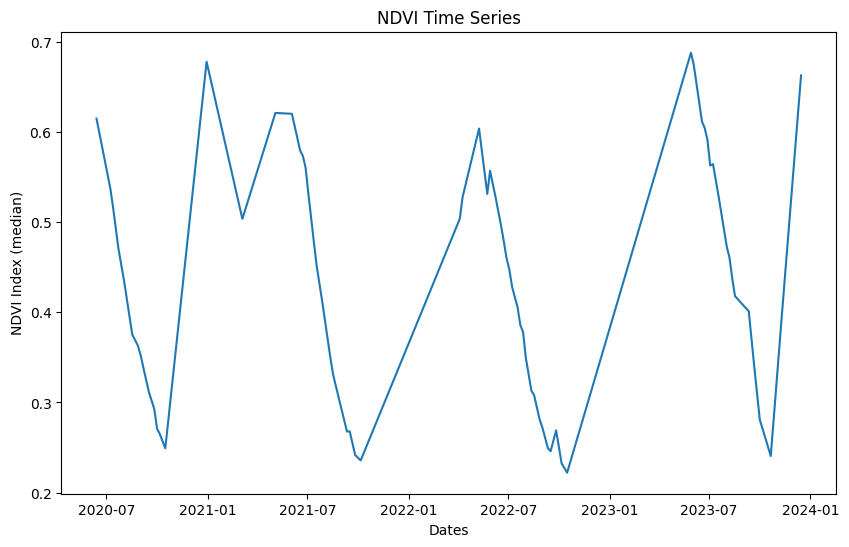

In [19]:
plt.figure(figsize=(10,6))
plt.plot(dates, ndvi_values)
plt.xlabel('Dates')
plt.ylabel('NDVI Index (median)')
plt.title('NDVI Time Series')
fig = plt.gcf()
plt.show()
fig.savefig('../images/NDVI_time_series.png', format='png')

In [12]:
#Selecionar os anos

years_list = [["2020-01-01", "2020-12-31"], ["2021-01-01", "2021-12-31"], ["2022-01-01", "2022-12-31"], ["2023-01-01", "2023-12-31"]]

In [20]:
#Refazer todo o processo anterior porém selecionando apenas a primeira imagem de cada ano dentro da coleção de imagens
#Adicionar cada uma das imagens ao mapa
#Salvar cada imagem em um arquivo separado

def plot_map(years_list:list):
  Map = geemap.Map()
  for start_date, end_date in years_list:
    print(start_date, end_date)
    imagecollection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                        .filterBounds(roi)\
                        .filterDate(start_date, end_date)\
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1))
    ndvi = imagecollection.map(scale).map(index)
    images = ndvi.first()
    vis_params = {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green', 'darkgreen']}
    Map.addLayer(images.select('NDVI'), vis_params, f'NDVI {start_date[:4]}')
    output_path = f'../images/tif/NDVI{start_date[:4]}.tif'
    save_images = geemap.ee_export_image(
    images.select('NDVI'),
    filename=output_path,
    scale=10,
    region=roi,
    crs='EPSG:31983',
    file_per_band=False)
    print(save_images)
  Map.centerObject(roi, 13)
  Map.add_colorbar_branca(
    colors = vis_params["palette"],
    vmin = 0,
    vmax = 1,
    categorical=True,
    step=4,
    transparent_bg = True,
    caption = "NDVI Index")
  return Map

In [21]:
plot_map(years_list=years_list)

2020-01-01 2020-12-31
Generating URL ...
Please wait ...
Data downloaded to c:\Users\bea-0\Desktop\projetos_python\meu_primeiro_projeto\images\tif\NDVI2020.tif
None
2021-01-01 2021-12-31
Generating URL ...
Please wait ...
Data downloaded to c:\Users\bea-0\Desktop\projetos_python\meu_primeiro_projeto\images\tif\NDVI2021.tif
None
2022-01-01 2022-12-31
Generating URL ...
Please wait ...
Data downloaded to c:\Users\bea-0\Desktop\projetos_python\meu_primeiro_projeto\images\tif\NDVI2022.tif
None
2023-01-01 2023-12-31
Generating URL ...
Please wait ...
Data downloaded to c:\Users\bea-0\Desktop\projetos_python\meu_primeiro_projeto\images\tif\NDVI2023.tif
None


Map(center=[-12.191779393756269, -45.52732431279195], controls=(WidgetControl(options=['position', 'transparen…

In [22]:
#Definir os argumentos do vídeo

video_args = {
    'dimensions': 500,
    'region': roi,
    'framesPerSecond': 2,
    'bands': ['NDVI'],
    'palette': ['red', 'yellow', 'green', 'darkgreen'],
    'min': 0,
    'max': 1,
}

In [26]:
#Definir o local para salvar o GIF

video_output_path = "../videos/ndvi.gif"

In [27]:
#Definir o dado de entrada
#Fazer o download

input = ndvi_images
geemap.download_ee_video(input, video_args, video_output_path)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\bea-0\Desktop\projetos_python\meu_primeiro_projeto\videos\ndvi.gif


In [28]:
#Visualizar o GIF

processed_dates_list = [date.strftime("%Y-%b") for date in dates]
geemap.add_text_to_gif(video_output_path, video_output_path, xy=('75%', '5%'), text_sequence=processed_dates_list, font_size=20, font_color='#ffffff', add_progress_bar=False, duration=300)
geemap.show_image(video_output_path)

Output()